# Potential Host Counting

One early question we we want to ask is "How many possible host galaxies are there in each image?" ([#4](https://github.com/chengsoonong/crowdastro/issues/4)). To answer this question I will first need to determine how confidently labelled each example is, a question which is covered in Banfield et al. (2015). This will allow me to find the dimmest confidently classified example. This will then be the lower brightness threshold for potential hosts. Finally, I will count how many hosts are in each image.

Every subject has some associated classifications (from which I will eventually derive the labels). There are usually multiple classifications. The *consensus* for a given subject is defined by Banfield et al. as

$$
C = \frac{n_{\text{consensus}}}{n_{\text{all}}}
$$

where $n_{\text{consensus}}$ is the number of classifications in agreement with the most common classification for a subject, and $n_{\text{all}}$ is the total number of classifications for the subject.

How do we determine "agreement"? There are two components to this: agreement on which radio observations are components of the same source, and agreement on which infrared source is the host galaxy. Radio observation agreement is easy since participants select predefined contours and these are included in the dataset. The classification itself, however, is an $(x, y)$ coordinate. These coordinates could vary but still represent the same infrared source. I'll follow the approach taken by Banfield et al. and use a kernel-density estimator (KDE) with the click locations. The Banfield et al. paper gives no threshold for whether two clicks are counted as agreeing, so I will have to choose this threshold myself (which I will do later, once I have seen some data).

An implementation of the consensus computation is located [here](https://github.com/willettk/rgz-analysis) for Python 2. I'll be doing something quite similar here.

For this notebook, I'll use the same subject as Banfield et al.: FIRSTJ124610.0+384838 (ARG000180p).

## Setting up the data

This section just loads the subject and shows it, along with all associated clicks.

In [48]:
import collections
import io
import itertools
import os
import pprint

import matplotlib.pyplot
import numpy
import PIL
import pymongo
import requests
import skimage.exposure
import skimage.feature
import scipy.ndimage.filters
import scipy.ndimage.morphology
import scipy.stats

%matplotlib inline

HOST = 'localhost'
PORT = 27017
DB_NAME = 'radio'

IMAGE_SCALE = 500/424

RGZ_CACHE = os.path.join(os.path.dirname(os.getcwd()), 'rgz_cache')

In [2]:
# Setup MongoDB.
client = pymongo.MongoClient(HOST, PORT)
db = client[DB_NAME]

In [3]:
# Load the subject.
subject = db.radio_subjects.find_one({'zooniverse_id': 'ARG000180p'})

In [4]:
# Download the images associated with this subject.
infrared = PIL.Image.open(io.BytesIO(requests.get(subject['location']['standard']).content))
radio = PIL.Image.open(io.BytesIO(requests.get(subject['location']['radio']).content))
combined = PIL.Image.blend(infrared, radio, 0.5)

In [5]:
# Find the classifications associated with this subject.
classifications = list(db.radio_classifications.find({'subject_ids': subject['_id']}))

An example classification:

```python
{'_id': ObjectId('52b1dd4e4258ec455d001f91'),
 'annotations': [{'ir': {'0': {'x': '251.5', 'y': '212'}},
                  'radio': {'0': {'xmax': '102.32255232729742',
                                  'xmin': '87.5456431846481',
                                  'ymax': '72.12894883061881',
                                  'ymin': '62.77882105432897'},
                            '1': {'xmax': '71.01281894294526',
                                  'xmin': '56.02975587403343',
                                  'ymax': '69.5085910834056',
                                  'ymin': '62.2958306709543'}}},
                 {'finished_at': '',
                  'started_at': ''},
                 {'user_agent': ''}],
 'created_at': datetime.datetime(2013, 12, 18, 17, 37, 19),
 'project_id': ObjectId('52afdb804d69636532000001'),
 'subject_ids': [ObjectId('52af820baf2fdc059a005621')],
 'subjects': [{'id': ObjectId('52af820baf2fdc059a005621'),
               'location': {'contours': 'http://radio.galaxyzoo.org/subjects/contours/52af820baf2fdc059a005621.json',
                            'radio': 'http://radio.galaxyzoo.org/subjects/radio/52af820baf2fdc059a005621.jpg',
                            'standard': 'http://radio.galaxyzoo.org/subjects/standard/52af820baf2fdc059a005621.jpg'},
               'zooniverse_id': 'ARG000180p'}],
 'tutorial': False,
 'updated_at': datetime.datetime(2013, 12, 18, 17, 37, 18, 452000),
 'user_id': ObjectId('52b0a0f62b60f168a9000013'),
 'user_ip': '',
 'user_name': '',
 'workflow_id': ObjectId('52afdb804d69636532000002')}
```

In [6]:
# Get the click locations.
clicks = []
for c in classifications:
    if 'ir' not in c['annotations'][0] or c['annotations'][0]['ir'] == 'No Sources':
        continue
    
    c_clicks = c['annotations'][0]['ir']
    for click in c_clicks.values():
        clicks.append((float(click['x']), float(click['y'])))
clicks = numpy.array(clicks)
clicks_x, clicks_y = clicks.T

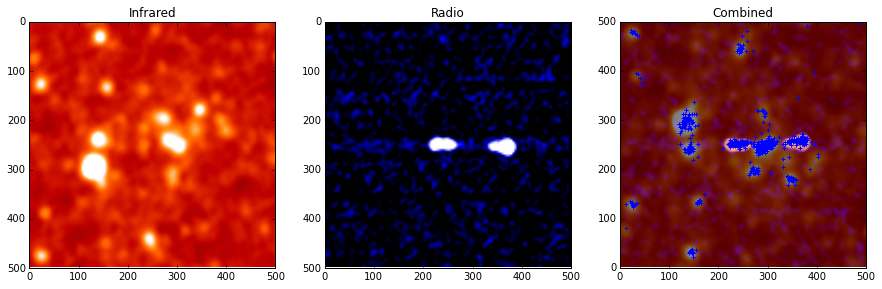

In [7]:
# Plot the images.
matplotlib.pyplot.figure(figsize=(15, 15))
matplotlib.pyplot.subplot(1, 3, 1)
matplotlib.pyplot.imshow(infrared)
matplotlib.pyplot.title('Infrared')
matplotlib.pyplot.subplot(1, 3, 2)
matplotlib.pyplot.imshow(radio)
matplotlib.pyplot.title('Radio')
matplotlib.pyplot.subplot(1, 3, 3)
matplotlib.pyplot.imshow(combined)
matplotlib.pyplot.scatter(clicks_x*IMAGE_SCALE, clicks_y*IMAGE_SCALE, marker='+')
matplotlib.pyplot.xlim((0, 500))
matplotlib.pyplot.ylim((0, 500))
matplotlib.pyplot.title('Combined')
matplotlib.pyplot.show()

The clicks don't line up unless multiplied by a constant. The [data description](https://github.com/willettk/rgz-analysis/blob/master/RadioGalaxyZoo_datadescription.ipynb) mentions a scaling factor but no such factor is included here; instead, this is due to the rescaling of the images for web viewing. The scale factor is $500/424$.

## Calculating Consensus

In [8]:
# List of signatures, immutable objects uniquely representing combinations of radio sources.
radio_signatures = []

# I'll also gather up all the click locations while I'm at it.
# This dict maps single radio signatures to lists of clicks for that specific signature.
radio_signature_to_clicks = collections.defaultdict(list)

for classification in classifications:
    # Generate a radio signature for each classification.
    classification_radio_signature = []

    galaxies = [annotation for annotation in classification['annotations'] if 'ir' in annotation]
    for galaxy in galaxies:
        # Generate a signature for each radio contours combination. This is just a sorted list of all the xmax values
        # associated with radio contours in the combination.
        if galaxy['radio'] == 'No Contours':
            radio_signature = ()
        else:
            radio_signature = tuple(sorted({
                    round(float(r['xmax']), 15)  # There's floating point precision errors in the data.
                    for r in galaxy['radio'].values()
            }))
        classification_radio_signature.append(radio_signature)
        
        if galaxy['ir'] == 'No Sources':
            continue  # Totally ignoring this case for now.
        else:
            # I'm also ignoring the case where there are multiple clicks.
            # The GitHub code associated with the paper also seems to do this.
            click = (float(galaxy['ir']['0']['x']), float(galaxy['ir']['0']['y']))
        radio_signature_to_clicks[radio_signature].append(click)
    
    classification_radio_signature = tuple(sorted(classification_radio_signature))
    radio_signatures.append(classification_radio_signature)

for signature, clicks in radio_signature_to_clicks.items():
    radio_signature_to_clicks[signature] = numpy.array(clicks)

In [9]:
# Sanity check: About 10% of participants split the radio sources.
print(len([s for s in radio_signatures if len(s) == 2])/len(radio_signatures))

0.10923694779116466


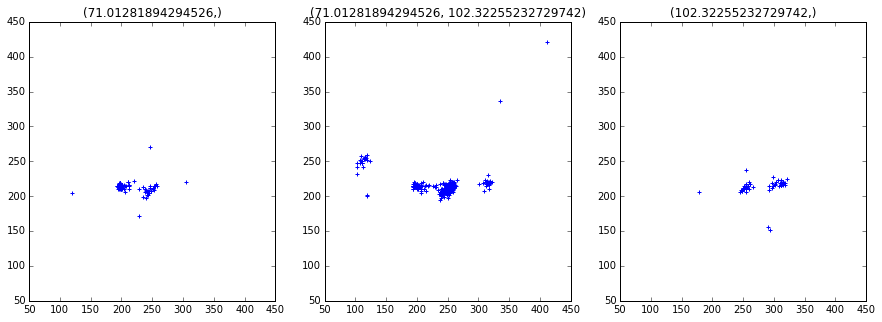

In [10]:
# Sanity check: Let's look at the clicks.
matplotlib.pyplot.figure(figsize=(15, 5))
for index, (signature, clicks) in enumerate(radio_signature_to_clicks.items()):
    matplotlib.pyplot.subplot(1, len(radio_signature_to_clicks), index + 1)
    xs, ys = clicks.T
    matplotlib.pyplot.scatter(xs, ys, marker='+')
    matplotlib.pyplot.title(str(signature))
    matplotlib.pyplot.xlim((50, 450))
    matplotlib.pyplot.ylim((50, 450))
matplotlib.pyplot.show()

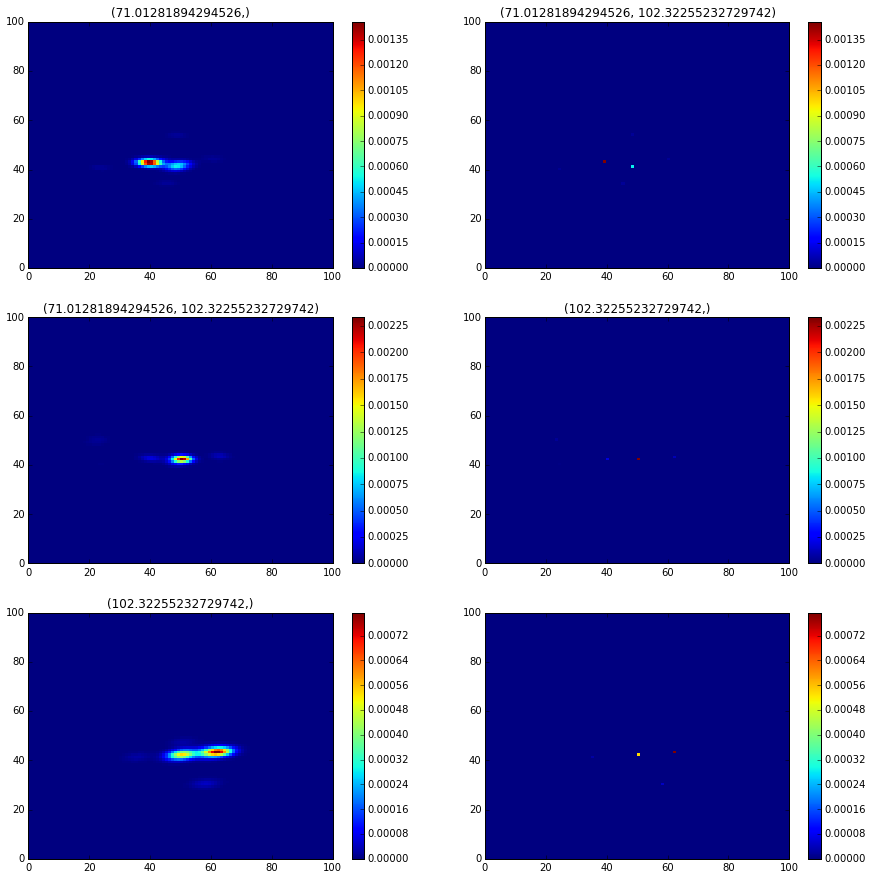

In [11]:
# Now we'll check the click location consensus. This will be computed for each radio combination.
matplotlib.pyplot.figure(figsize=(15, 15))

radio_signature_to_click_density_peaks = {}
radio_signature_to_plurality_click = {}
for index, (signature, clicks) in enumerate(radio_signature_to_clicks.items()):
    clicks += numpy.random.normal(size=clicks.shape)
    kernel = scipy.stats.kde.gaussian_kde(clicks.T)
    X, Y = numpy.mgrid[0:500:100j, 0:500:100j]
    positions = numpy.vstack([X.ravel(), Y.ravel()])
    density = kernel(positions).T.reshape(X.shape)

    matplotlib.pyplot.title(str(signature))
    matplotlib.pyplot.subplot(len(radio_signature_to_clicks), 2, index * 2 + 1)
    matplotlib.pyplot.pcolor(density.T)
    matplotlib.pyplot.colorbar()
    
    # From https://github.com/willettk/rgz-analysis
    neighborhood = numpy.ones((5, 5))
    local_max = scipy.ndimage.filters.maximum_filter(density, footprint=neighborhood) == density
    eroded_background = scipy.ndimage.morphology.binary_erosion(density == 0, structure=neighborhood, border_value=1)
    detected_peaks = local_max ^ eroded_background
    weighted_peaks = detected_peaks * density
    
    # Find all click peaks.
    all_clicks = numpy.transpose(detected_peaks.nonzero()) * 5
    radio_signature_to_click_density_peaks[signature] = all_clicks
    
    # Find the plurality click.
    plurality_click = numpy.array(numpy.unravel_index(weighted_peaks.argmax(), weighted_peaks.shape)) * 5
    radio_signature_to_plurality_click[signature] = plurality_click
    
    matplotlib.pyplot.title(str(signature))
    matplotlib.pyplot.subplot(len(radio_signature_to_clicks), 2, index * 2 + 2)
    matplotlib.pyplot.pcolor(weighted_peaks.T)
    matplotlib.pyplot.colorbar()

matplotlib.pyplot.show()

At this point, I can't follow the paper any further &mdash; it doesn't provide any way of identifying which clicks agree with the plurality vote. I definitely need to figure out a good way to deal with this properly but for now I'll check which peak is closest to any given click.

In [12]:
# Find the plurality radio signature.
radio_signature_counts = collections.Counter()
for radio_signature in radio_signatures:
    radio_signature_counts[radio_signature] += 1

plurality_radio_signature = max(radio_signature_counts, key=radio_signature_counts.get)
print(plurality_radio_signature)

((71.01281894294526, 102.32255232729742),)


In [13]:
# For each classification, check whether the radio signature matches the plurality radio signature.
# If it does, check whether the click matches the plurality click for each galaxy.
# If it does, then this classification agrees with the consensus. Else it does not.

n_consensus = 0
n_all = len(classifications)

for classification, classification_radio_signature in zip(classifications, radio_signatures):
    if classification_radio_signature != plurality_radio_signature:
        continue

    galaxies = [annotation for annotation in classification['annotations'] if 'ir' in annotation]
    for galaxy in galaxies:
        # Regenerate the signature for this radio combination so we can look up the associated click peaks.
        if galaxy['radio'] == 'No Contours':
            radio_signature = ()
        else:
            radio_signature = tuple(sorted({
                    round(float(r['xmax']), 15)
                    for r in galaxy['radio'].values()
            }))
        
        if galaxy['ir'] == 'No Sources':
            continue
        
        click = (float(galaxy['ir']['0']['x']), float(galaxy['ir']['0']['y']))
        
        # Find the closest click density peak.
        peaks = radio_signature_to_click_density_peaks[radio_signature]
        closest_peak = min(peaks, key=lambda peak: numpy.hypot(click[0] - peak[0], click[1] - peak[1]))
        if (closest_peak != radio_signature_to_plurality_click[radio_signature]).any():
            break
    else:
        n_consensus += 1
    
print('{:.02%}'.format(n_consensus / n_all))

62.73%


This seems a lot lower than what the paper seems to imply, but maybe this is because of my method of finding which peak was clicked. The next thing I'll want to do is run this over a lot of data, so let's try that. I'll bundle it up in a function.

In [195]:
def click_peaks(clicks, kernel_size=10):
    kernel = scipy.stats.kde.gaussian_kde(clicks.T)
    X, Y = numpy.mgrid[0:500:100j, 0:500:100j]
    positions = numpy.vstack([X.ravel(), Y.ravel()])
    density = kernel(positions).T.reshape(X.shape)

    # From https://github.com/willettk/rgz-analysis
    neighborhood = numpy.ones((kernel_size, kernel_size))
    local_max = scipy.ndimage.filters.maximum_filter(density, footprint=neighborhood) == density
    eroded_background = scipy.ndimage.morphology.binary_erosion(density == 0, structure=neighborhood, border_value=1)
    detected_peaks = local_max ^ eroded_background
    weighted_peaks = detected_peaks * density

    # Find all click peaks.
    all_clicks = numpy.transpose(detected_peaks.nonzero()) * 5

    # Find the plurality click.
    plurality_click = numpy.array(numpy.unravel_index(weighted_peaks.argmax(), weighted_peaks.shape)) * 5

    return all_clicks, plurality_click

In [198]:
def consensus(zid, subject=None):
    """Computes the consensus for a given Zooniverse object.

    zid: Zooniverse ID.
    subject: (Optional) Zooniverse subject. If not specified, will be loaded from database.
    -> float, percentage consensus.
    """
    if subject is None:
        subject = db.radio_subjects.find_one({'zooniverse_id': zid})

    classifications = list(db.radio_classifications.find({'subject_ids': subject['_id']}))
    
    if not classifications:
        return 1.0

    radio_signatures = []
    radio_signature_to_clicks = collections.defaultdict(list)

    for classification in classifications:
        # Generate a radio signature for each classification.
        classification_radio_signature = []

        galaxies = [annotation for annotation in classification['annotations'] if 'ir' in annotation]
        for galaxy in galaxies:
            # Generate a signature for each radio contours combination. This is just a sorted list of all the xmax values
            # associated with radio contours in the combination.
            if galaxy['radio'] == 'No Contours':
                radio_signature = ()
            else:
                radio_signature = tuple(sorted({
                        round(float(r['xmax']), 15)  # There's floating point precision errors in the data.
                        for r in galaxy['radio'].values()
                }))
            classification_radio_signature.append(radio_signature)

            if galaxy['ir'] == 'No Sources':
                continue  # Totally ignoring this case for now.

            # I'm also ignoring the case where there are multiple clicks.
            # The GitHub code associated with the paper also seems to do this.
            click = (float(galaxy['ir']['0']['x']), float(galaxy['ir']['0']['y']))
            radio_signature_to_clicks[radio_signature].append(click)

        classification_radio_signature = tuple(sorted(classification_radio_signature))
        radio_signatures.append(classification_radio_signature)

    for signature, clicks in radio_signature_to_clicks.items():
        radio_signature_to_clicks[signature] = numpy.array(clicks)
        
    radio_signature_to_click_density_peaks = {}
    radio_signature_to_plurality_click = {}

    for index, (signature, clicks) in enumerate(radio_signature_to_clicks.items()):
        if len(clicks) == 1:
            radio_signature_to_click_density_peaks[signature] = [clicks[0]]
            plurality_click = clicks[0]
        else:
            clicks += numpy.random.normal(size=clicks.shape)
            all_clicks, plurality_click = click_peaks(clicks)
            radio_signature_to_click_density_peaks[signature] = all_clicks

        radio_signature_to_plurality_click[signature] = plurality_click
    
    # Find the plurality radio signature.
    radio_signature_counts = collections.Counter()
    for radio_signature in radio_signatures:
        radio_signature_counts[radio_signature] += 1

    plurality_radio_signature = max(radio_signature_counts, key=radio_signature_counts.get)

    n_consensus = 0
    n_all = len(classifications)

    for classification, classification_radio_signature in zip(classifications, radio_signatures):
        if classification_radio_signature != plurality_radio_signature:
            continue

        galaxies = [annotation for annotation in classification['annotations'] if 'ir' in annotation]

        for galaxy in galaxies:
            # Regenerate the signature for this radio combination so we can look up the associated click peaks.
            if galaxy['radio'] == 'No Contours':
                radio_signature = ()
            else:
                radio_signature = tuple(sorted({
                        round(float(r['xmax']), 15)
                        for r in galaxy['radio'].values()
                }))

            if galaxy['ir'] == 'No Sources':
                continue

            click = (float(galaxy['ir']['0']['x']), float(galaxy['ir']['0']['y']))

            # Find the closest click density peak.
            peaks = radio_signature_to_click_density_peaks[radio_signature]
            if len(peaks) == 0:
                continue

            closest_peak = min(peaks, key=lambda peak: numpy.hypot(click[0] - peak[0], click[1] - peak[1]))
            if (closest_peak != radio_signature_to_plurality_click[radio_signature]).any():
                break
        else:
            n_consensus += 1

    return n_consensus / n_all

In [199]:
# Sanity check: Let's try it on the same subject as before.
consensus('ARG000180p')

0.6273092369477912

Now let's run that on some more subjects.

K:\Languages\Anaconda\lib\site-packages\scipy\stats\kde.py:517: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance)) * self.n
K:\Languages\Anaconda\lib\site-packages\scipy\stats\kde.py:234: RuntimeWarning: overflow encountered in exp
  result = result + exp(-energy)


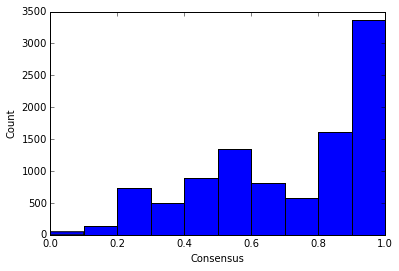

In [174]:
cs = [consensus(subject['zooniverse_id']) for subject in db.radio_subjects.find().limit(10000)]
matplotlib.pyplot.hist(cs, bins=10)
matplotlib.pyplot.xlabel('Consensus')
matplotlib.pyplot.ylabel('Count')
matplotlib.pyplot.show()

In [175]:
# Sanity check: The mean consensus found by Banfield et al. was 0.67.
print(numpy.mean(cs))

0.709182329677


That's a higher average than it should be (though note that trying this on 1000 subjects results in ~0.67 &mdash; maybe the paper only uses some of the data).

## Finding Host Brightnesses

We now need to figure out how bright each host galaxy is. We will find the plurality click, and then check the pixel value of the associated infrared image. Since the images are at different exposures, I also want to try equalising the value histogram of the image and seeing if this makes the distribution of brightnesses more compact.

I'll also have to cache the data I'm downloading locally somehow. I don't want to burden the RGZ servers too much.

In [146]:
# We need a function that will cache the data I download locally.

def get_infrared_image(subject):
    """Gets the infrared image of a subject.
    
    subject: RGZ subject dict.
    -> [[float]]
    """
    image_path = os.path.join(RGZ_CACHE, 'subject_{}.png'.format(subject['zooniverse_id']))
    try:
        im = PIL.Image.open(image_path)
    except FileNotFoundError:
        image_data = requests.get(subject['location']['standard']).content
        with open(image_path, 'wb') as image_file:
            image_file.write(image_data)

        im = PIL.Image.open(image_path)

    return numpy.array(im.convert('L').getdata()).reshape(im.size).T / 255
#     return im.convert('L')

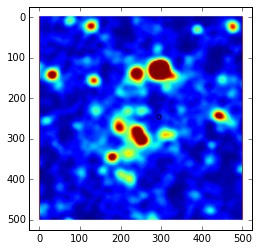

1.0


In [148]:
# Check that works.
point = (250*IMAGE_SCALE, 210*IMAGE_SCALE)
matplotlib.pyplot.imshow(
        get_infrared_image(db.radio_subjects.find_one({'zooniverse_id': 'ARG000180p'}))
)
matplotlib.pyplot.scatter([point[0]], [point[1]])
matplotlib.pyplot.show()

print(get_infrared_image(db.radio_subjects.find_one({'zooniverse_id': 'ARG000180p'}))[point])

In [168]:
def classification_brightnesses(zid, subject=None):
    """Find out how bright a given classified object is.
    
    zid: Zooniverse ID.
    subject: (Optional) Zooniverse subject. If not specified, will be loaded from database.
    -> [float] Brightnesses of classifications in the subject.
    """
    if subject is None:
        subject = db.radio_subjects.find_one({'zooniverse_id': zid})

    classifications = list(db.radio_classifications.find({'subject_ids': subject['_id']}))
    
    if not classifications:
        return []

    radio_signatures = []
    radio_signature_to_clicks = collections.defaultdict(list)

    for classification in classifications:
        # Generate a radio signature for each classification.
        classification_radio_signature = []

        galaxies = [annotation for annotation in classification['annotations'] if 'ir' in annotation]
        for galaxy in galaxies:
            # Generate a signature for each radio contours combination. This is just a sorted list of all the xmax values
            # associated with radio contours in the combination.
            if galaxy['radio'] == 'No Contours':
                radio_signature = ()
            else:
                radio_signature = tuple(sorted({
                        round(float(r['xmax']), 15)  # There's floating point precision errors in the data.
                        for r in galaxy['radio'].values()
                }))
            classification_radio_signature.append(radio_signature)

            if galaxy['ir'] == 'No Sources':
                continue  # Totally ignoring this case for now.

            # I'm also ignoring the case where there are multiple clicks.
            # The GitHub code associated with the paper also seems to do this.
            click = (float(galaxy['ir']['0']['x']), float(galaxy['ir']['0']['y']))
            radio_signature_to_clicks[radio_signature].append(click)

        classification_radio_signature = tuple(sorted(classification_radio_signature))
        radio_signatures.append(classification_radio_signature)
    
    # Find the plurality radio signature.
    radio_signature_counts = collections.Counter()
    for radio_signature in radio_signatures:
        radio_signature_counts[radio_signature] += 1
    plurality_radio_signature = max(radio_signature_counts, key=radio_signature_counts.get)
    
    infrared = get_infrared_image(subject)
    
    values = []

    for signature in plurality_radio_signature:
        clicks = numpy.array(radio_signature_to_clicks[signature])
        if len(clicks) == 0:
            continue
        if len(clicks) == 1:
            plurality_click = clicks[0]
        else:
            clicks += numpy.random.normal(size=clicks.shape)
            _, plurality_click = click_peaks(clicks)
        
        value = infrared[tuple(plurality_click * IMAGE_SCALE)]
        values.append(value)

    return values

In [169]:
# Try this out on the example subject.
classification_brightnesses('ARG000180p')

[1.0]

K:\Languages\Anaconda\lib\site-packages\scipy\stats\kde.py:517: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance)) * self.n
K:\Languages\Anaconda\lib\site-packages\scipy\stats\kde.py:234: RuntimeWarning: overflow encountered in exp
  result = result + exp(-energy)


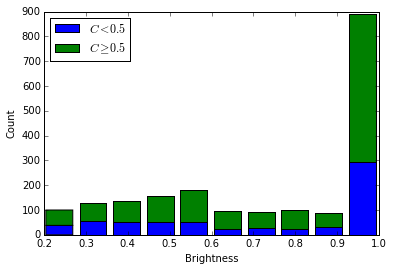

In [189]:
# Let's try running that on more subjects. We also want to split on confidence - maybe it's harder to label dimmer subjects.
brightnesses_low_consensus = []
brightnesses_high_consensus = []
for subject in db.radio_subjects.find().limit(2500):
    c = consensus(subject['zooniverse_id'], subject)
    brightnesses = classification_brightnesses(subject['zooniverse_id'], subject)
    if c < 0.5:
        brightnesses_low_consensus.extend(brightnesses)
    else:
        brightnesses_high_consensus.extend(brightnesses)

matplotlib.pyplot.hist([brightnesses_low_consensus, brightnesses_high_consensus], bins=10, stacked=True)
matplotlib.pyplot.legend(['$C < 0.5$', '$C \\geq 0.5$'], loc='upper left')
matplotlib.pyplot.xlabel('Brightness')
matplotlib.pyplot.ylabel('Count')
matplotlib.pyplot.show()

In [194]:
print('High consensus mean:', numpy.mean(brightnesses_high_consensus))
print('High consensus median:', numpy.median(brightnesses_high_consensus))
print('High consensus min:', min(brightnesses_high_consensus))

print('Low consensus mean:', numpy.mean(brightnesses_low_consensus))
print('Low consensus median:', numpy.median(brightnesses_low_consensus))
print('Low consensus min:', min(brightnesses_low_consensus))

High consensus mean: 0.750915328424
High consensus median: 0.835294117647
High consensus min: 0.196078431373
Low consensus mean: 0.730767593859
Low consensus median: 0.835294117647
Low consensus min: 0.196078431373


So there's no apparent difference between the brightnesses of subjects with different consensus levels.

Now we need to find out how many potential subjects there are in each image. I expect these supermassive black holes to be in the middle of galaxies, so I would also expect the host we want to click on to be a local brightness maximum. I can't think of any scenarios where this isn't true and a human classifier would be able to get around it. Thus I'll find all local maxima across some subjects and then count how many there are for each subject. I'll also threshold the maxima at 0.190 in line with the findings above.

The first thing I want to do is figure out a good way of getting local maxima. Let's repurpose the same approach used by Banfield et al. (since I already reimplemented that anyway!).

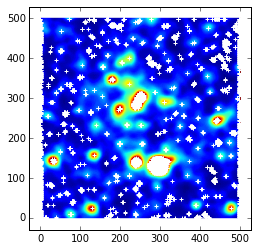

In [223]:
infrared = get_infrared_image(db.radio_subjects.find_one({'zooniverse_id': 'ARG000180p'}))
neighborhood = numpy.ones((10, 10))
local_max = scipy.ndimage.filters.maximum_filter(infrared, footprint=neighborhood) == infrared
local_max = local_max.nonzero()
matplotlib.pyplot.imshow(infrared, origin='lower')
matplotlib.pyplot.scatter(local_max[1], local_max[0], c='w', marker='+')
matplotlib.pyplot.show()

We can see that there's a lot of peaks, and not all of them look useful. Let's run a low-pass filter on the image first and see if that has any effect.

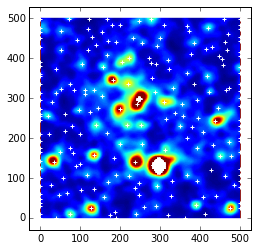

In [227]:
blurred_infrared = scipy.ndimage.filters.gaussian_filter(infrared, 1)
local_max = scipy.ndimage.filters.maximum_filter(blurred_infrared, footprint=neighborhood) == blurred_infrared
local_max = local_max.nonzero()
matplotlib.pyplot.imshow(infrared, origin='lower')
matplotlib.pyplot.scatter(local_max[1], local_max[0], c='w', marker='+')
matplotlib.pyplot.show()
# eroded_background = scipy.ndimage.morphology.binary_erosion(density == 0, structure=neighborhood, border_value=1)
# detected_peaks = local_max ^ eroded_background
# weighted_peaks = detected_peaks * density

This is a bit better. Next, let's try and collapse those contiguous regions into single features.

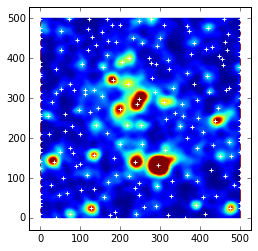

In [247]:
blurred_infrared = scipy.ndimage.filters.gaussian_filter(infrared, 1)
local_max = scipy.ndimage.filters.maximum_filter(blurred_infrared, footprint=neighborhood) == blurred_infrared
region_labels, n_labels = scipy.ndimage.measurements.label(local_max)
maxima = numpy.array(
            [numpy.array((region_labels == i + 1).nonzero()).T.mean(axis=0)
             for i in range(n_labels)]
)
matplotlib.pyplot.imshow(infrared, origin='lower')
matplotlib.pyplot.scatter(maxima[:, 1], maxima[:, 0], c='w', marker='+')
matplotlib.pyplot.show()

That looks pretty good! Now, let's get rid of all those peaks on the sides.

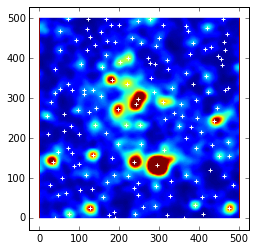

In [259]:
maxima = maxima[numpy.logical_and(maxima[:, 1] != 0, maxima[:, 1] != 499)]
matplotlib.pyplot.imshow(infrared, origin='lower')
matplotlib.pyplot.scatter(maxima[:, 1], maxima[:, 0], c='w', marker='+')
matplotlib.pyplot.show()

I'll get the pixel values of each point and see what kinds of values we're looking at.

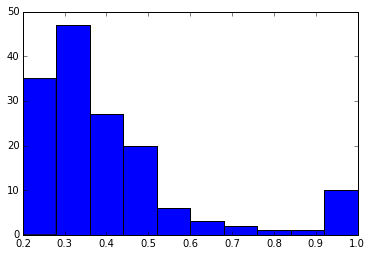

Min: 0.2


In [266]:
values = [infrared[tuple(m)] for m in maxima]
matplotlib.pyplot.hist(values)
matplotlib.pyplot.show()

print('Min:', min(values))

It seems most peaks are pretty dim. Maybe we could bias toward the centre, but I'm not sure that's a good idea &mdash; I'll look at it later. Let's check out the distribution of the number of peaks across all data.